In [1]:
#warnings off
import warnings
warnings.filterwarnings('ignore')

# - 'station_origin': the origin station
# - 'station_destination': the destination station
# - 'flows': the number of people commuting from origin to destination
# - 'population': the population of each station
# - 'jobs': the number of jobs at each station
# - 'distance': the distance between stations


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import folium
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats
import numpy as np
from math import sqrt

In [3]:
def CalcRSquared(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE

In [4]:
# Read in the edgelist file from csv
SIM = pd.read_csv("london_flows.csv")
# Remove rows where 'population', 'jobs', or 'distance' have zero values
SIM = SIM[(SIM["population"] > 0) & (SIM["jobs"] > 0) & (SIM["distance"] > 0)]


SIM.info

<bound method DataFrame.info of          station_origin station_destination  flows  population   jobs  \
0            Abbey Road   Bank and Monument      0         599  78549   
1            Abbey Road             Beckton      1         599    442   
2            Abbey Road           Blackwall      3         599    665   
3            Abbey Road        Canary Wharf      1         599  58772   
4            Abbey Road        Canning Town     37         599  15428   
...                 ...                 ...    ...         ...    ...   
61469  Woolwich Arsenal       Tower Gateway    127        7892   3342   
61470  Woolwich Arsenal            West Ham    608        7892   5487   
61471  Woolwich Arsenal     West India Quay      6        7892    400   
61472  Woolwich Arsenal     West Silvertown     81        7892    893   
61473  Woolwich Arsenal           Westferry     76        7892   1250   

           distance  
0       8131.525097  
1       8510.121774  
2       3775.448872  
3  

In [5]:
SIM.head(10)

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167
5,Abbey Road,Crossharbour,1,599,1208,6686.475560
6,Abbey Road,Custom House,0,599,845,3824.855630
7,Abbey Road,Cutty Sark,2,599,1748,8503.898909
8,Abbey Road,Cyprus,7,599,850,6532.099618
9,Abbey Road,Devons Road,1,599,611,3958.324171


In [6]:
# Create a pivot table to find the actual flows between stations
flow_matrix = pd.pivot_table(SIM, values='flows', index='station_origin', columns='station_destination', aggfunc=np.sum, fill_value=0)
# 计算每个 'station_origin' 的总和
total_flows = flow_matrix.sum(axis=1)  # axis=1 指示按行求和

# 将总和作为新列添加到 'flow_matrix'
flow_matrix['total'] = total_flows
# Display the Origin-Destination (OD) matrix
print(flow_matrix)

station_destination  Abbey Road  Acton Central  Acton Town  Aldgate  \
station_origin                                                        
Abbey Road                    0              0           0        0   
Acton Central                 0              0           0        0   
Acton Town                    0              0           0        3   
Aldgate                       0              0           0        0   
Aldgate East                  0              0           2        0   
...                         ...            ...         ...      ...   
Wood Street                   0              0           0        0   
Woodford                      0              0           2        5   
Woodgrange Park               0              0           0        0   
Woodside Park                 0              0           1       26   
Woolwich Arsenal             20              0           0        0   

station_destination  Aldgate East  All Saints  Alperton  Amersham  Anerley  

In [7]:
# Get the flow between specific stations
# Example: finding the flow from 'Abbey Road' to 'Canning Town'
origin_station = 'Abbey Road'
destination_station = 'Canning Town'

flow_value = flow_matrix.loc[origin_station, destination_station]
print(f"Flow from {origin_station} to {destination_station}: {flow_value}")

Flow from Abbey Road to Canning Town: 37


In [8]:
#Calculate log of destination employment count with small addition to solve div by zero error
SIM['log_Dist'] = np.log(SIM['distance'] + 0.001)
SIM['log_jobs'] = np.log(SIM['jobs'] + 0.001)
SIM['Total'] = SIM['flows']
SIM

,station_origin,station_destination,flows,population,jobs,distance,log_Dist,log_jobs,Total
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,9.003504,11.271478,0
1,Abbey Road,Beckton,1,599,442,8510.121774,9.049012,6.091312,1
2,Abbey Road,Blackwall,3,599,665,3775.448872,8.236275,6.499789,3
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,8.534348,10.981421,1
4,Abbey Road,Canning Town,37,599,15428,2228.923167,7.709274,9.643939,37
...,...,...,...,...,...,...,...,...,...
61469,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,9.503144,8.114325,127
61470,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,9.071246,8.610137,608
61471,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,9.162905,5.991467,6
61472,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,8.585833,6.794588,81


In [9]:
SIM.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61413 entries, 0 to 61473
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   station_origin       61413 non-null  object 
 1   station_destination  61413 non-null  object 
 2   flows                61413 non-null  int64  
 3   population           61413 non-null  int64  
 4   jobs                 61413 non-null  int64  
 5   distance             61413 non-null  float64
 6   log_Dist             61413 non-null  float64
 7   log_jobs             61413 non-null  float64
 8   Total                61413 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 4.7+ MB


In [10]:
#SIM['station_origin'] = SIM['station_origin'].astype('category')
#SIM['station_destination'] = SIM['station_destination'].astype('category')

In [11]:
#df = SIM[SIM['station_origin'] != SIM['station_destination']]

In [12]:
#create the formula (the "-1" indicates no intercept in the regression model).
#formula = "flows ~ station_origin + log_jobs + log_Dist-1"
formula = "flows ~ station_origin + log_jobs + distance -1"
#run a doubly constrained sim
prodSim = smf.glm(formula = formula, data=SIM, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(prodSim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61013
Model Family:                 Poisson   Df Model:                          399
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.0994e+05
Date:                Mon, 29 Apr 2024   Deviance:                   1.6477e+06
Time:                        21:35:31   Pearson chi2:                 2.40e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [13]:
#random_sample = df.sample(n=1000, random_state=42)

In [14]:
#create the formula (the "-1" indicates no intercept in the regression model).
#formula = "flows ~ station_origin + log_jobs + log_Dist-1"
#run a doubly constrained sim
#prodSim = smf.glm(formula = formula, data=df, family=sm.families.Poisson()).fit()
#print(prodSim.summary())

So, what do we have?

Well, there are the elements of the model output that should be familiar from the unconstrained model:

The $\gamma$ parameter related to the destination attractiveness: 0.8157

The $\beta$ distance decay parameter: 0.1229  . Recall the negative sign in the equation.

We can see from the standard outputs from the model that almost all of the explanatory variables are statistically significant (P>|z| < 0.01) and the z-scores indicate that the destination job (salary) is having the most influence on the model, with distance following closely behind. And then we have a series of paramaters which are the vector of $\alpha_i$ values associated with our origin constraints.

## 2.1 Model Estimates

In [15]:
#SIM['Total'] = SIM.groupby('station_origin')['flows'].transform(np.sum)

In [16]:
#create some Oi and Dj columns in the dataframe and store row and column totals in them:

O_i = pd.DataFrame(SIM.groupby(["station_origin"])["Total"].agg(np.sum))
O_i.rename(columns={"Total":"O_i"}, inplace = True)
SIM = SIM.merge(O_i, on = "station_origin", how = "left" )

D_j = pd.DataFrame(SIM.groupby(["station_destination"])["Total"].agg(np.sum))
D_j.rename(columns={"Total":"D_j"}, inplace = True)
SIM = SIM.merge(D_j, on = "station_destination", how = "left" )

In [17]:
#Now we want to fish the coefficients out of the prodSim glm object.
coefs = pd.DataFrame(prodSim.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"alpha_i", "index":"coef"}, inplace = True)
to_repl = ["(station_origin)", "\[", "\]"]
for x in to_repl:
    coefs["coef"] = coefs["coef"].str.replace(x, "",regex=True)
coefs
SIM = SIM.merge(coefs, left_on="station_origin", right_on="coef", how = "left")
SIM.drop(columns = ["coef"], inplace = True)
SIM.head(50)


,station_origin,station_destination,flows,population,jobs,distance,log_Dist,log_jobs,Total,O_i,D_j,alpha_i
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,9.003504,11.271478,0,599,78549,-2.914324
1,Abbey Road,Beckton,1,599,442,8510.121774,9.049012,6.091312,1,599,442,-2.914324
2,Abbey Road,Blackwall,3,599,665,3775.448872,8.236275,6.499789,3,599,665,-2.914324
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,8.534348,10.981421,1,599,58772,-2.914324
4,Abbey Road,Canning Town,37,599,15428,2228.923167,7.709274,9.643939,37,599,15428,-2.914324
5,Abbey Road,Crossharbour,1,599,1208,6686.475560,8.807842,7.096722,1,599,1208,-2.914324
6,Abbey Road,Custom House,0,599,845,3824.855630,8.249276,6.739338,0,599,845,-2.914324
7,Abbey Road,Cutty Sark,2,599,1748,8503.898909,9.048280,7.466228,2,599,1748,-2.914324
8,Abbey Road,Cyprus,7,599,850,6532.099618,8.784484,6.745238,7,599,850,-2.914324
9,Abbey Road,Devons Road,1,599,611,3958.324171,8.283576,6.415099,1,599,611,-2.914324


In [18]:
num_coefficients = len(prodSim.params)
print(f"The GLM model has {num_coefficients} coefficients.")

The GLM model has 400 coefficients.


In [19]:
alpha_i = prodSim.params[0:398]
gamma = prodSim.params[398]
beta = -prodSim.params[399]

In [20]:
alpha_i

station_origin[Abbey Road]         -2.914324
station_origin[Acton Central]      -1.162094
station_origin[Acton Town]         -1.613083
station_origin[Aldgate]            -2.943050
station_origin[Aldgate East]       -2.854754
                                      ...   
station_origin[Wood Street]        -0.942623
station_origin[Woodford]           -0.633608
station_origin[Woodgrange Park]    -0.896424
station_origin[Woodside Park]      -1.149112
station_origin[Woolwich Arsenal]    0.518039
Length: 398, dtype: float64

In [21]:
gamma

0.7552218112088518

In [22]:
beta

0.00015316618613609736

In [23]:
pd.options.display.float_format = '{:.5f}'.format

And we're ready to generate our estimates:

In [24]:
SIM["prodsimest1"] = np.exp(SIM["alpha_i"]+gamma*SIM["log_jobs"] 
                                 - beta*SIM["distance"])
#or you could do it the easy way like we did last week with the fitted column (See previous practical)
SIM

,station_origin,station_destination,flows,population,jobs,distance,log_Dist,log_jobs,Total,O_i,D_j,alpha_i,prodsimest1
0,Abbey Road,Bank and Monument,0,599,78549,8131.52510,9.00350,11.27148,0,599,78549,-2.91432,77.68538
1,Abbey Road,Beckton,1,599,442,8510.12177,9.04901,6.09131,1,599,442,-2.91432,1.46595
2,Abbey Road,Blackwall,3,599,665,3775.44887,8.23627,6.49979,3,599,665,-2.91432,4.12137
3,Abbey Road,Canary Wharf,1,599,58772,5086.51422,8.53435,10.98142,1,599,58772,-2.91432,99.48454
4,Abbey Road,Canning Town,37,599,15428,2228.92317,7.70927,9.64394,37,599,15428,-2.91432,56.12568
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61408,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.79555,9.50314,8.11433,127,7892,3342,0.51804,98.83502
61409,Woolwich Arsenal,West Ham,608,7892,5487,8701.45436,9.07125,8.61014,608,7892,5487,0.51804,295.25325
61410,Woolwich Arsenal,West India Quay,6,7892,400,9536.72045,9.16291,5.99147,6,7892,400,0.51804,35.95335
61411,Woolwich Arsenal,West Silvertown,81,7892,893,5355.24855,8.58583,6.79459,81,7892,893,0.51804,125.11290


## 2.2 Assessing the model output

So what do the outputs from our Production Constrained Model look like? How has the goodness-of-fit improved and how can we start to use this a bit like a retail model and assess the likley impacts of changing detsination attractiveness etc.?

### 2.2.1 The flow matrix

In [25]:
#first round the estimates
SIM["prodsimest1"] = round(SIM["prodsimest1"],0)
#now we can create a pivot tabel to turn the paired list into a matrix, and compute the margins as well
flow_matrix2 = SIM.pivot_table(values ="prodsimest1", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
#flow_matrix2.fillna(0, inplace=True)
pd.options.display.float_format = '{:.0f}'.format
flow_matrix2

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,595
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,1226
Acton Town,NaN,NaN,NaN,13,13,NaN,14,0,NaN,16,...,13,3,2,20,NaN,0,NaN,1,NaN,3744
Aldgate,NaN,NaN,1,NaN,37,NaN,NaN,0,NaN,27,...,2,NaN,2,2,NaN,1,NaN,1,NaN,2885
Aldgate East,NaN,NaN,1,40,NaN,NaN,0,0,NaN,29,...,2,0,3,2,NaN,1,NaN,1,NaN,3160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,1,41,52,NaN,NaN,NaN,NaN,30,...,2,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN,4867
Woodgrange Park,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532
Woodside Park,NaN,NaN,2,19,19,NaN,0,NaN,NaN,32,...,3,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,3100


In [26]:
flow_matrix

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,total
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,32,599
Acton Central,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1224
Acton Town,0,0,0,3,17,0,35,0,0,11,...,77,3,6,9,0,0,0,0,0,3745
Aldgate,0,0,0,0,0,0,0,0,0,17,...,0,0,4,8,0,0,0,0,0,2886
Aldgate East,0,0,2,0,0,0,0,0,0,20,...,24,0,0,12,0,1,0,1,0,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wood Street,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1367
Woodford,0,0,2,5,47,0,0,0,0,22,...,2,0,1,0,0,0,0,0,0,4868
Woodgrange Park,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,530


### 2.2.2 How do the fits compare with the unconstrained model from last time?

In [27]:
CalcRSquared(SIM["flows"], SIM["prodsimest1"])

0.4680653367257205

In [28]:
CalcRMSE(SIM["flows"], SIM["prodsimest1"])

96.263

### IV. Scenarios

### Scenario A:

In [29]:
SIM2 = SIM

In [30]:
def new_jobs(row):
    if row["station_destination"] == "Canary Wharf":
        val = 29386
    else:
        val = row["jobs"]
    return val
SIM2["jobs_A"] = SIM2.apply(new_jobs, axis=1)
     

In [31]:
pd.options.display.float_format = '{:.5f}'.format

In [32]:
SIM2

,station_origin,station_destination,flows,population,jobs,distance,log_Dist,log_jobs,Total,O_i,D_j,alpha_i,prodsimest1,jobs_A
0,Abbey Road,Bank and Monument,0,599,78549,8131.52510,9.00350,11.27148,0,599,78549,-2.91432,78.00000,78549
1,Abbey Road,Beckton,1,599,442,8510.12177,9.04901,6.09131,1,599,442,-2.91432,1.00000,442
2,Abbey Road,Blackwall,3,599,665,3775.44887,8.23627,6.49979,3,599,665,-2.91432,4.00000,665
3,Abbey Road,Canary Wharf,1,599,58772,5086.51422,8.53435,10.98142,1,599,58772,-2.91432,99.00000,29386
4,Abbey Road,Canning Town,37,599,15428,2228.92317,7.70927,9.64394,37,599,15428,-2.91432,56.00000,15428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61408,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.79555,9.50314,8.11433,127,7892,3342,0.51804,99.00000,3342
61409,Woolwich Arsenal,West Ham,608,7892,5487,8701.45436,9.07125,8.61014,608,7892,5487,0.51804,295.00000,5487
61410,Woolwich Arsenal,West India Quay,6,7892,400,9536.72045,9.16291,5.99147,6,7892,400,0.51804,36.00000,400
61411,Woolwich Arsenal,West Silvertown,81,7892,893,5355.24855,8.58583,6.79459,81,7892,893,0.51804,125.00000,893


In [33]:
# Given DataFrame 'df'
canary_wharf_rows = SIM2[SIM2["station_destination"] == "Canary Wharf"]

# Display the first few rows with 'Canary Wharf' as the station_destination
print(canary_wharf_rows.head())

# Get the total number of rows with 'Canary Wharf'
total_canary_wharf_rows = canary_wharf_rows.shape[0]
print(f"Total rows with 'Canary Wharf': {total_canary_wharf_rows}")
# Display the count



    station_origin station_destination  flows  population   jobs    distance  \
3       Abbey Road        Canary Wharf      1         599  58772  5086.51422   
126     Acton Town        Canary Wharf     57        3745  58772 20398.16588   
348        Aldgate        Canary Wharf      1        2886  58772  6564.41968   
595   Aldgate East        Canary Wharf      3        3172  58772  5127.99890   
817     All Saints        Canary Wharf     67         740  58772  1340.08873   

     log_Dist  log_jobs  Total   O_i    D_j  alpha_i  prodsimest1  jobs_A  
3     8.53435  10.98142      1   599  58772 -2.91432     99.00000   29386  
126   9.92320  10.98142     57  3745  58772 -1.61308     35.00000   29386  
348   8.78942  10.98142      1  2886  58772 -2.94305     77.00000   29386  
595   8.54247  10.98142      3  3172  58772 -2.85475    105.00000   29386  
817   7.20049  10.98142     67   740  58772 -2.87832    183.00000   29386  
Total rows with 'Canary Wharf': 304


In [34]:
canary_wharf_rows.head(10)

,station_origin,station_destination,flows,population,jobs,distance,log_Dist,log_jobs,Total,O_i,D_j,alpha_i,prodsimest1,jobs_A
3,Abbey Road,Canary Wharf,1,599,58772,5086.51422,8.53435,10.98142,1,599,58772,-2.91432,99.00000,29386
126,Acton Town,Canary Wharf,57,3745,58772,20398.16588,9.92320,10.98142,57,3745,58772,-1.61308,35.00000,29386
348,Aldgate,Canary Wharf,1,2886,58772,6564.41968,8.78942,10.98142,1,2886,58772,-2.94305,77.00000,29386
595,Aldgate East,Canary Wharf,3,3172,58772,5127.99890,8.54247,10.98142,3,3172,58772,-2.85475,105.00000,29386
817,All Saints,Canary Wharf,67,740,58772,1340.08873,7.20049,10.98142,67,740,58772,-2.87832,183.00000,29386
872,Alperton,Canary Wharf,7,1624,58772,25371.25383,10.14137,10.98142,7,1624,58772,-1.65425,16.00000,29386
1028,Amersham,Canary Wharf,54,1190,58772,49907.63568,10.81793,10.98142,54,1190,58772,1.00076,5.00000,29386
1220,Angel,Canary Wharf,96,4199,58772,8538.42637,9.05233,10.98142,96,4199,58772,-2.58752,81.00000,29386
1479,Archway,Canary Wharf,51,5642,58772,14463.51988,9.57938,10.98142,51,5642,58772,-1.71637,78.00000,29386
1706,Arnos Grove,Canary Wharf,37,3046,58772,19708.92700,9.88883,10.98142,37,3046,58772,-1.41839,47.00000,29386


In [35]:
#calculate some new Dj^gamma and d_ij^beta values
Dj1_gamma = SIM2["jobs"]**gamma
dist_beta = np.exp(SIM2['distance']*-beta)
#calcualte the first stage of the Ai values
SIM2["Ai1"] = Dj1_gamma * dist_beta

#now do the sum over all js bit
A_i = pd.DataFrame(SIM.groupby(["station_origin"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i"}, inplace=True)
#and write the A_i values back into the dataframe
SIM2 = SIM2.merge(A_i, left_on="station_origin", right_index=True, how="left")


In [36]:
SIM2['A_i'] = SIM2['A_i'].apply(lambda x: f'{x:.6f}')
SIM2

,station_origin,station_destination,flows,population,jobs,distance,log_Dist,log_jobs,Total,O_i,D_j,alpha_i,prodsimest1,jobs_A,Ai1,A_i
0,Abbey Road,Bank and Monument,0,599,78549,8131.52510,9.00350,11.27148,0,599,78549,-2.91432,78.00000,78549,1432.23477,0.000091
1,Abbey Road,Beckton,1,599,442,8510.12177,9.04901,6.09131,1,599,442,-2.91432,1.00000,442,27.02675,0.000091
2,Abbey Road,Blackwall,3,599,665,3775.44887,8.23627,6.49979,3,599,665,-2.91432,4.00000,665,75.98302,0.000091
3,Abbey Road,Canary Wharf,1,599,58772,5086.51422,8.53435,10.98142,1,599,58772,-2.91432,99.00000,29386,1834.13186,0.000091
4,Abbey Road,Canning Town,37,599,15428,2228.92317,7.70927,9.64394,37,599,15428,-2.91432,56.00000,15428,1034.75262,0.000091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61408,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.79555,9.50314,8.11433,127,7892,3342,0.51804,99.00000,3342,58.87480,0.000213
61409,Woolwich Arsenal,West Ham,608,7892,5487,8701.45436,9.07125,8.61014,608,7892,5487,0.51804,295.00000,5487,175.87871,0.000213
61410,Woolwich Arsenal,West India Quay,6,7892,400,9536.72045,9.16291,5.99147,6,7892,400,0.51804,36.00000,400,21.41693,0.000213
61411,Woolwich Arsenal,West Silvertown,81,7892,893,5355.24855,8.58583,6.79459,81,7892,893,0.51804,125.00000,893,74.52816,0.000213


In [37]:
print(SIM2['A_i'].dtype)

object


In [38]:
SIM2['A_i'] = pd.to_numeric(SIM2['A_i'], errors='coerce')


In [39]:
print(SIM2['A_i'].dtype)

float64


In [40]:
SIM2["prodsimest2"] = SIM2["A_i"]*SIM2["O_i"]*Dj1_gamma*dist_beta
#round
SIM2["prodsimest2"] = round(SIM2["prodsimest2"])
#check
SIM2[["prodsimest1", "prodsimest2"]]

,prodsimest1,prodsimest2
0,78.00000,78.00000
1,1.00000,1.00000
2,4.00000,4.00000
3,99.00000,100.00000
4,56.00000,56.00000
...,...,...
61408,99.00000,99.00000
61409,295.00000,296.00000
61410,36.00000,36.00000
61411,125.00000,125.00000


### use new estimates

In [41]:
#calculate some new Dj^gamma and d_ij^beta values
Dj2_gamma = SIM2["jobs_A"]**gamma

#calcualte the first stage of the Ai values
SIM2["Ai1"] = Dj2_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(SIM.groupby(["station_origin"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i2"}, inplace=True)
#and write the A_i values back into the dataframe
SIM2 = SIM2.merge(A_i, left_on="station_origin", right_index=True, how="left")

In [66]:
gamma

0.7552218112088518

In [64]:
dist_beta

0       0.00686
1       0.00544
2       0.09896
3       0.04432
4       0.25523
          ...  
61408   0.00027
61409   0.00484
61410   0.00290
61411   0.03759
61412   0.00224
Name: distance, Length: 61413, dtype: float64

In [65]:
SIM2

,station_origin,station_destination,flows,population,jobs,distance,log_Dist,log_jobs,Total,O_i,...,jobs_A,Ai1,A_i,prodsimest2,A_i2,prodsimest3,A_i3,prodsimest4,A_i4,prodsimest5
0,Abbey Road,Bank and Monument,0,599,78549,8131.52510,9.00350,11.27148,0,599,...,78549,34.14333,0.00009,78.00000,0.00009,78.00000,0.00009,22.00000,0.00009,2.00000
1,Abbey Road,Beckton,1,599,442,8510.12177,9.04901,6.09131,1,599,...,442,0.54142,0.00009,1.00000,0.00009,1.00000,0.00009,0.00000,0.00009,0.00000
2,Abbey Road,Blackwall,3,599,665,3775.44887,8.23627,6.49979,3,599,...,665,13.40592,0.00009,4.00000,0.00009,4.00000,0.00009,2.00000,0.00009,1.00000
3,Abbey Road,Canary Wharf,1,599,58772,5086.51422,8.53435,10.98142,1,599,...,29386,177.16484,0.00009,100.00000,0.00009,59.00000,0.00009,46.00000,0.00009,10.00000
4,Abbey Road,Canning Town,37,599,15428,2228.92317,7.70927,9.64394,37,599,...,15428,371.56755,0.00009,56.00000,0.00009,56.00000,0.00009,40.00000,0.00009,20.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61408,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.79555,9.50314,8.11433,127,7892,...,3342,0.12459,0.00021,99.00000,0.00021,99.00000,0.00021,13.00000,0.00021,0.00000
61409,Woolwich Arsenal,West Ham,608,7892,5487,8701.45436,9.07125,8.61014,608,7892,...,5487,3.22679,0.00021,296.00000,0.00021,295.00000,0.00021,78.00000,0.00021,5.00000
61410,Woolwich Arsenal,West India Quay,6,7892,400,9536.72045,9.16291,5.99147,6,7892,...,400,0.26769,0.00021,36.00000,0.00021,36.00000,0.00021,8.00000,0.00021,0.00000
61411,Woolwich Arsenal,West Silvertown,81,7892,893,5355.24855,8.58583,6.79459,81,7892,...,893,6.36267,0.00021,125.00000,0.00021,125.00000,0.00021,55.00000,0.00021,11.00000


In [42]:
SIM2["prodsimest3"] = SIM2["A_i2"]*SIM2["O_i"]*Dj2_gamma*dist_beta
#round
SIM2["prodsimest3"] = round(SIM2["prodsimest3"])
#check
SIM2[["prodsimest2", "prodsimest3"]]

,prodsimest2,prodsimest3
0,78.00000,78.00000
1,1.00000,1.00000
2,4.00000,4.00000
3,100.00000,59.00000
4,56.00000,56.00000
...,...,...
61408,99.00000,99.00000
61409,296.00000,295.00000
61410,36.00000,36.00000
61411,125.00000,125.00000


In [43]:
#SIM2['change_ScenA'] = SIM2['prodsimest3'] - SIM2['prodsimest2']
#SIM2['percent_change_ScenA'] = ((SIM2['prodsimest3'] - SIM2['prodsimest2']) / SIM2['prodsimest2']) * 100

In [44]:
SIM2

,station_origin,station_destination,flows,population,jobs,distance,log_Dist,log_jobs,Total,O_i,D_j,alpha_i,prodsimest1,jobs_A,Ai1,A_i,prodsimest2,A_i2,prodsimest3
0,Abbey Road,Bank and Monument,0,599,78549,8131.52510,9.00350,11.27148,0,599,78549,-2.91432,78.00000,78549,1432.23477,0.00009,78.00000,0.00009,78.00000
1,Abbey Road,Beckton,1,599,442,8510.12177,9.04901,6.09131,1,599,442,-2.91432,1.00000,442,27.02675,0.00009,1.00000,0.00009,1.00000
2,Abbey Road,Blackwall,3,599,665,3775.44887,8.23627,6.49979,3,599,665,-2.91432,4.00000,665,75.98302,0.00009,4.00000,0.00009,4.00000
3,Abbey Road,Canary Wharf,1,599,58772,5086.51422,8.53435,10.98142,1,599,58772,-2.91432,99.00000,29386,1086.64112,0.00009,100.00000,0.00009,59.00000
4,Abbey Road,Canning Town,37,599,15428,2228.92317,7.70927,9.64394,37,599,15428,-2.91432,56.00000,15428,1034.75262,0.00009,56.00000,0.00009,56.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61408,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.79555,9.50314,8.11433,127,7892,3342,0.51804,99.00000,3342,58.87480,0.00021,99.00000,0.00021,99.00000
61409,Woolwich Arsenal,West Ham,608,7892,5487,8701.45436,9.07125,8.61014,608,7892,5487,0.51804,295.00000,5487,175.87871,0.00021,296.00000,0.00021,295.00000
61410,Woolwich Arsenal,West India Quay,6,7892,400,9536.72045,9.16291,5.99147,6,7892,400,0.51804,36.00000,400,21.41693,0.00021,36.00000,0.00021,36.00000
61411,Woolwich Arsenal,West Silvertown,81,7892,893,5355.24855,8.58583,6.79459,81,7892,893,0.51804,125.00000,893,74.52816,0.00021,125.00000,0.00021,125.00000


### Scenario B1 and B2

#### Scenario B1: increase beta by two times

In [45]:
beta2 = beta * 2

In [46]:
#calculate some new Dj^gamma and d_ij^beta values
Dj3_gamma = SIM2["jobs"]**gamma
#beta = beta * 2
dist_beta = np.exp(SIM2['distance']*-beta2)
#calcualte the first stage of the Ai values
SIM2["Ai1"] = Dj3_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(SIM.groupby(["station_origin"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i3"}, inplace=True)
#and write the A_i values back into the dataframe
SIM2 = SIM2.merge(A_i, left_on="station_origin", right_index=True, how="left")
SIM2.head()

,station_origin,station_destination,flows,population,jobs,distance,log_Dist,log_jobs,Total,O_i,D_j,alpha_i,prodsimest1,jobs_A,Ai1,A_i,prodsimest2,A_i2,prodsimest3,A_i3
0,Abbey Road,Bank and Monument,0,599,78549,8131.52510,9.00350,11.27148,0,599,78549,-2.91432,78.00000,78549,412.20327,0.00009,78.00000,0.00009,78.00000,0.00009
1,Abbey Road,Beckton,1,599,442,8510.12177,9.04901,6.09131,1,599,442,-2.91432,1.00000,442,7.34019,0.00009,1.00000,0.00009,1.00000,0.00009
2,Abbey Road,Blackwall,3,599,665,3775.44887,8.23627,6.49979,3,599,665,-2.91432,4.00000,665,42.61638,0.00009,4.00000,0.00009,4.00000,0.00009
3,Abbey Road,Canary Wharf,1,599,58772,5086.51422,8.53435,10.98142,1,599,58772,-2.91432,99.00000,29386,841.54927,0.00009,100.00000,0.00009,59.00000,0.00009
4,Abbey Road,Canning Town,37,599,15428,2228.92317,7.70927,9.64394,37,599,15428,-2.91432,56.00000,15428,735.47901,0.00009,56.00000,0.00009,56.00000,0.00009


In [47]:
beta

0.00015316618613609736

In [48]:
SIM2["prodsimest4"] = SIM2["A_i3"]*SIM2["O_i"]*Dj3_gamma*dist_beta
#round
SIM2["prodsimest4"] = round(SIM2["prodsimest4"])

In [49]:
SIM2

,station_origin,station_destination,flows,population,jobs,distance,log_Dist,log_jobs,Total,O_i,...,alpha_i,prodsimest1,jobs_A,Ai1,A_i,prodsimest2,A_i2,prodsimest3,A_i3,prodsimest4
0,Abbey Road,Bank and Monument,0,599,78549,8131.52510,9.00350,11.27148,0,599,...,-2.91432,78.00000,78549,412.20327,0.00009,78.00000,0.00009,78.00000,0.00009,22.00000
1,Abbey Road,Beckton,1,599,442,8510.12177,9.04901,6.09131,1,599,...,-2.91432,1.00000,442,7.34019,0.00009,1.00000,0.00009,1.00000,0.00009,0.00000
2,Abbey Road,Blackwall,3,599,665,3775.44887,8.23627,6.49979,3,599,...,-2.91432,4.00000,665,42.61638,0.00009,4.00000,0.00009,4.00000,0.00009,2.00000
3,Abbey Road,Canary Wharf,1,599,58772,5086.51422,8.53435,10.98142,1,599,...,-2.91432,99.00000,29386,841.54927,0.00009,100.00000,0.00009,59.00000,0.00009,46.00000
4,Abbey Road,Canning Town,37,599,15428,2228.92317,7.70927,9.64394,37,599,...,-2.91432,56.00000,15428,735.47901,0.00009,56.00000,0.00009,56.00000,0.00009,40.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61408,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.79555,9.50314,8.11433,127,7892,...,0.51804,99.00000,3342,7.55879,0.00021,99.00000,0.00021,99.00000,0.00021,13.00000
61409,Woolwich Arsenal,West Ham,608,7892,5487,8701.45436,9.07125,8.61014,608,7892,...,0.51804,295.00000,5487,46.38732,0.00021,296.00000,0.00021,295.00000,0.00021,78.00000
61410,Woolwich Arsenal,West India Quay,6,7892,400,9536.72045,9.16291,5.99147,6,7892,...,0.51804,36.00000,400,4.97029,0.00021,36.00000,0.00021,36.00000,0.00021,8.00000
61411,Woolwich Arsenal,West Silvertown,81,7892,893,5355.24855,8.58583,6.79459,81,7892,...,0.51804,125.00000,893,32.81658,0.00021,125.00000,0.00021,125.00000,0.00021,55.00000


#### Scenario B2: increase beta by four times

In [50]:
beta4 = beta * 4

In [51]:
beta4

0.0006126647445443894

In [52]:
#calculate some new Dj^gamma and d_ij^beta values
Dj4_gamma = SIM2["jobs"]**gamma
beta = beta*4
dist_beta = np.exp(SIM2['distance']*-beta4)
#calcualte the first stage of the Ai values
SIM2["Ai1"] = Dj4_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(SIM.groupby(["station_origin"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i4"}, inplace=True)
#and write the A_i values back into the dataframe
SIM2 = SIM2.merge(A_i, left_on="station_origin", right_index=True, how="left")

In [53]:
SIM2["prodsimest5"] = SIM2["A_i4"]*SIM2["O_i"]*Dj4_gamma*dist_beta
#round
SIM2["prodsimest5"] = round(SIM2["prodsimest5"])

In [54]:
SIM2

,station_origin,station_destination,flows,population,jobs,distance,log_Dist,log_jobs,Total,O_i,...,jobs_A,Ai1,A_i,prodsimest2,A_i2,prodsimest3,A_i3,prodsimest4,A_i4,prodsimest5
0,Abbey Road,Bank and Monument,0,599,78549,8131.52510,9.00350,11.27148,0,599,...,78549,34.14333,0.00009,78.00000,0.00009,78.00000,0.00009,22.00000,0.00009,2.00000
1,Abbey Road,Beckton,1,599,442,8510.12177,9.04901,6.09131,1,599,...,442,0.54142,0.00009,1.00000,0.00009,1.00000,0.00009,0.00000,0.00009,0.00000
2,Abbey Road,Blackwall,3,599,665,3775.44887,8.23627,6.49979,3,599,...,665,13.40592,0.00009,4.00000,0.00009,4.00000,0.00009,2.00000,0.00009,1.00000
3,Abbey Road,Canary Wharf,1,599,58772,5086.51422,8.53435,10.98142,1,599,...,29386,177.16484,0.00009,100.00000,0.00009,59.00000,0.00009,46.00000,0.00009,10.00000
4,Abbey Road,Canning Town,37,599,15428,2228.92317,7.70927,9.64394,37,599,...,15428,371.56755,0.00009,56.00000,0.00009,56.00000,0.00009,40.00000,0.00009,20.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61408,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.79555,9.50314,8.11433,127,7892,...,3342,0.12459,0.00021,99.00000,0.00021,99.00000,0.00021,13.00000,0.00021,0.00000
61409,Woolwich Arsenal,West Ham,608,7892,5487,8701.45436,9.07125,8.61014,608,7892,...,5487,3.22679,0.00021,296.00000,0.00021,295.00000,0.00021,78.00000,0.00021,5.00000
61410,Woolwich Arsenal,West India Quay,6,7892,400,9536.72045,9.16291,5.99147,6,7892,...,400,0.26769,0.00021,36.00000,0.00021,36.00000,0.00021,8.00000,0.00021,0.00000
61411,Woolwich Arsenal,West Silvertown,81,7892,893,5355.24855,8.58583,6.79459,81,7892,...,893,6.36267,0.00021,125.00000,0.00021,125.00000,0.00021,55.00000,0.00021,11.00000


In [55]:
Scenarios = SIM2[['station_origin','station_destination','flows','population','jobs','distance','prodsimest1','prodsimest2','prodsimest3','prodsimest4','prodsimest5']]
Scenarios['prodsimest2'] = SIM2['prodsimest2'].replace(0, 1)
Scenarios['percent_change_ScenA'] = ((Scenarios['prodsimest3'] - Scenarios['prodsimest2']) / Scenarios['prodsimest2']) * 100
Scenarios['percent_change_ScenB1'] = ((Scenarios['prodsimest4'] - Scenarios['prodsimest1']) / Scenarios['prodsimest1']) * 100
Scenarios['percent_change_ScenB2'] = ((Scenarios['prodsimest5'] - Scenarios['prodsimest1']) / Scenarios['prodsimest1']) * 100
Scenarios

,station_origin,station_destination,flows,population,jobs,distance,prodsimest1,prodsimest2,prodsimest3,prodsimest4,prodsimest5,percent_change_ScenA,percent_change_ScenB1,percent_change_ScenB2
0,Abbey Road,Bank and Monument,0,599,78549,8131.52510,78.00000,78.00000,78.00000,22.00000,2.00000,0.00000,-71.79487,-97.43590
1,Abbey Road,Beckton,1,599,442,8510.12177,1.00000,1.00000,1.00000,0.00000,0.00000,0.00000,-100.00000,-100.00000
2,Abbey Road,Blackwall,3,599,665,3775.44887,4.00000,4.00000,4.00000,2.00000,1.00000,0.00000,-50.00000,-75.00000
3,Abbey Road,Canary Wharf,1,599,58772,5086.51422,99.00000,100.00000,59.00000,46.00000,10.00000,-41.00000,-53.53535,-89.89899
4,Abbey Road,Canning Town,37,599,15428,2228.92317,56.00000,56.00000,56.00000,40.00000,20.00000,0.00000,-28.57143,-64.28571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61408,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.79555,99.00000,99.00000,99.00000,13.00000,0.00000,0.00000,-86.86869,-100.00000
61409,Woolwich Arsenal,West Ham,608,7892,5487,8701.45436,295.00000,296.00000,295.00000,78.00000,5.00000,-0.33784,-73.55932,-98.30508
61410,Woolwich Arsenal,West India Quay,6,7892,400,9536.72045,36.00000,36.00000,36.00000,8.00000,0.00000,0.00000,-77.77778,-100.00000
61411,Woolwich Arsenal,West Silvertown,81,7892,893,5355.24855,125.00000,125.00000,125.00000,55.00000,11.00000,0.00000,-56.00000,-91.20000


In [56]:
# Calculate descriptive statistics for 'prodsimest2'
stats_prodsimest2 = Scenarios['prodsimest2'].describe()
stats_prodsimest2['sum'] = Scenarios['prodsimest2'].sum()

# Calculate descriptive statistics for 'prodsimest3'
stats_prodsimest3 = Scenarios['prodsimest3'].describe()
stats_prodsimest3['sum'] = Scenarios['prodsimest3'].sum()

# Calculate descriptive statistics for 'prodsimest4'
stats_prodsimest4 = Scenarios['prodsimest4'].describe()
stats_prodsimest4['sum'] = Scenarios['prodsimest4'].sum()

# Calculate descriptive statistics for 'prodsimest5'
stats_prodsimest5 = Scenarios['prodsimest5'].describe()
stats_prodsimest5['sum'] = Scenarios['prodsimest5'].sum()



# Combine the statistics into a DataFrame
stats_compare = pd.DataFrame({'prodsimest2': stats_prodsimest2, 'prodsimest3': stats_prodsimest3, 'prodsimest4': stats_prodsimest4, 'prodsimest5': stats_prodsimest5})


stats_compare_table = stats_compare.applymap('{:.0f}'.format)

stats_compare_table

,prodsimest2,prodsimest3,prodsimest4,prodsimest5
count,61413,61413,61413,61413
mean,25,25,9,3
std,81,79,45,23
min,1,0,0,0
25%,1,1,0,0
50%,6,6,1,0
75%,20,20,4,0
max,3631,3686,2497,1607
sum,1549520,1521907,559127,176555


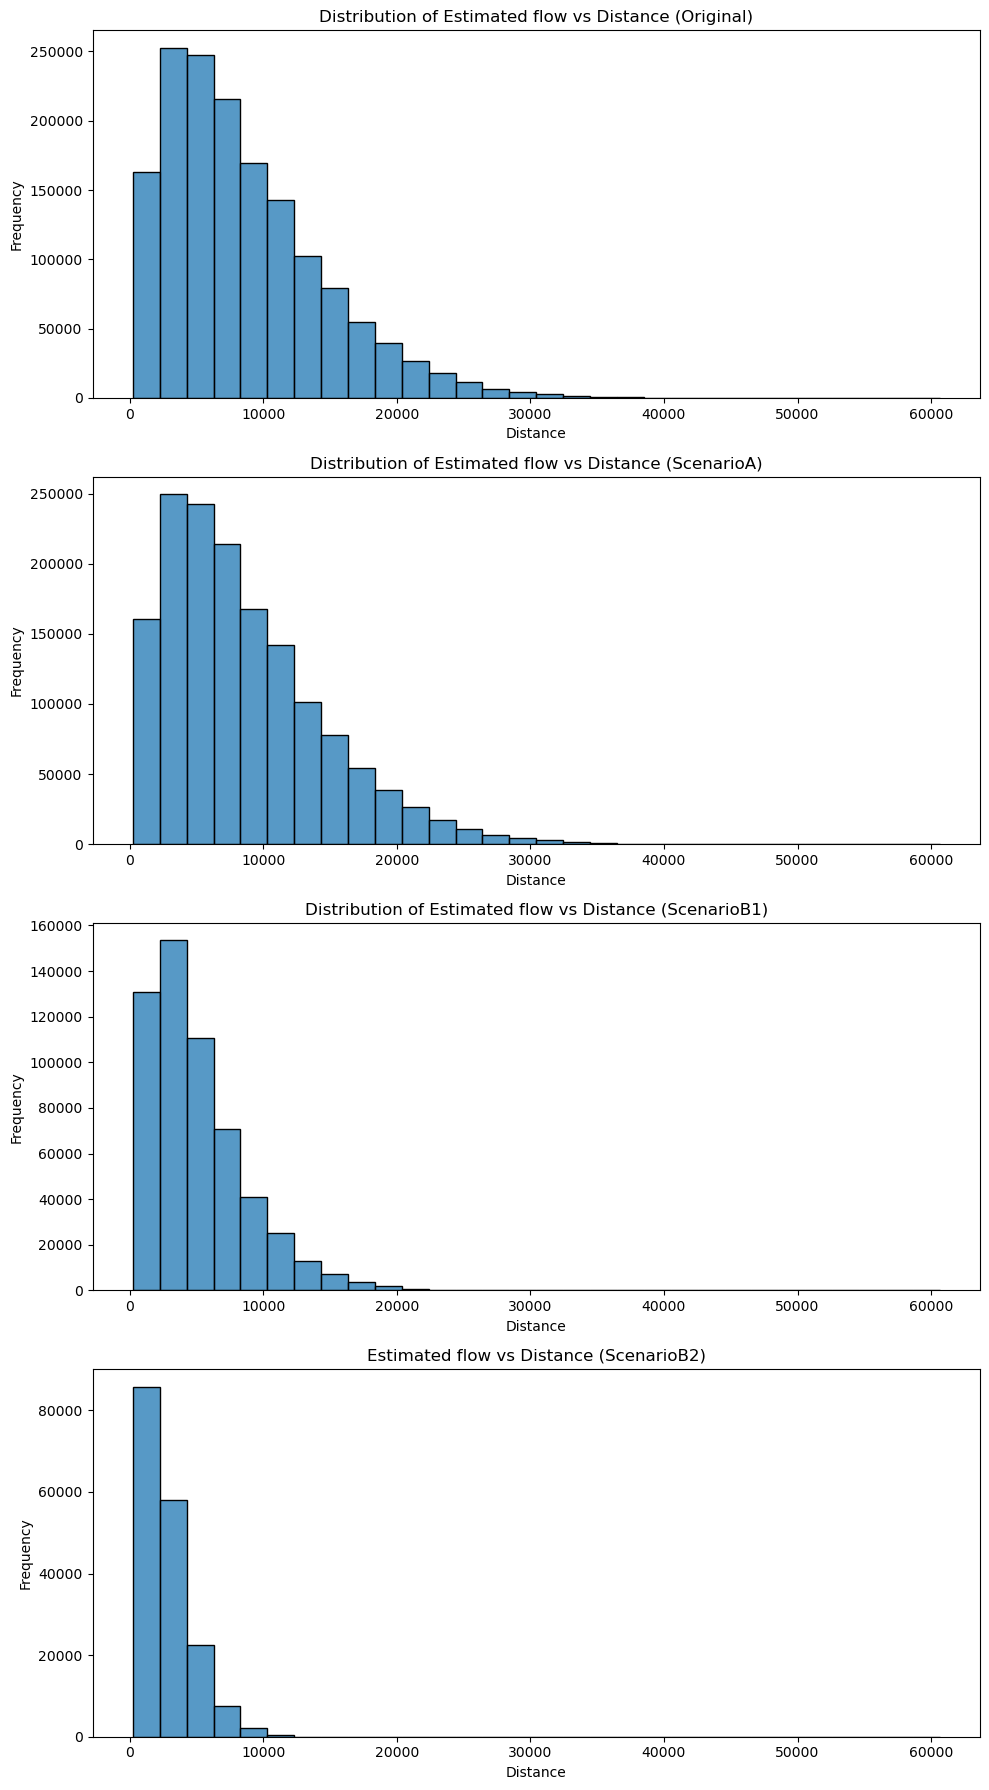

In [57]:
fig, axes = plt.subplots(4, 1, figsize=(10, 18))

# Plot for 'prodsimest2'
sns.histplot(SIM2, x='distance', weights='prodsimest2', bins=30, kde=False, ax=axes[0])
axes[0].set_title('Distribution of Estimated flow vs Distance (Original)')
axes[0].set_xlabel('Distance')
axes[0].set_ylabel('Frequency')

# Plot for 'prodsimest3'
sns.histplot(SIM2, x='distance', weights='prodsimest3', bins=30, kde=False, ax=axes[1])
axes[1].set_title('Distribution of Estimated flow vs Distance (ScenarioA)')
axes[1].set_xlabel('Distance')
axes[1].set_ylabel('Frequency')

# Plot for 'prodsimest4'
sns.histplot(SIM2, x='distance', weights='prodsimest4', bins=30, kde=False, ax=axes[2])
axes[2].set_title('Distribution of Estimated flow vs Distance (ScenarioB1)')
axes[2].set_xlabel('Distance')
axes[2].set_ylabel('Frequency')

# Plot for 'prodsimest5'
sns.histplot(SIM2, x='distance', weights='prodsimest5', bins=30, kde=False, ax=axes[3])
axes[3].set_title('Estimated flow vs Distance (ScenarioB2)')
axes[3].set_xlabel('Distance')
axes[3].set_ylabel('Frequency')

# Adjust layout for better visibility
plt.tight_layout()
#plt.savefig('Distribution of inter-site traffic flows over a range of distances.png')
plt.show()

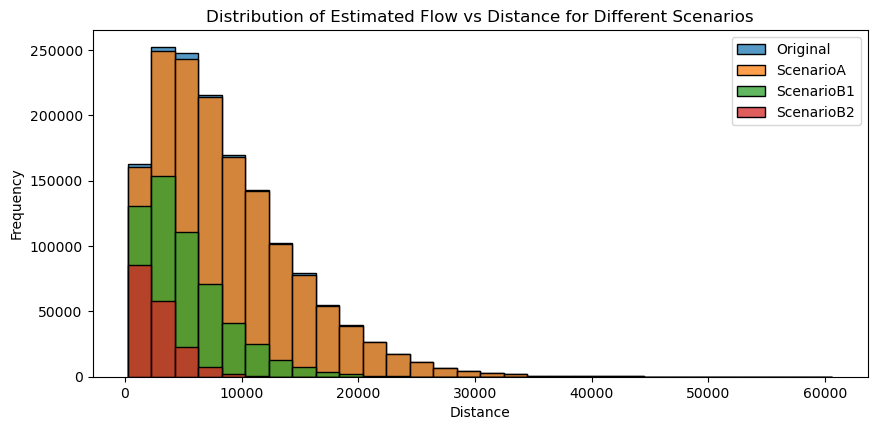

In [58]:
# Create a single figure and axis
fig, ax = plt.subplots(figsize=(10, 4.5))

# Use a palette with high contrast colors
palette = sns.color_palette("tab10")

# Plot for 'prodsimest2' with the first color in the palette
sns.histplot(SIM2, x='distance', weights='prodsimest2', bins=30, kde=False, color=palette[0], alpha=0.75, label='Original', ax=ax)

# Plot for 'prodsimest3' with the second color in the palette
sns.histplot(SIM2, x='distance', weights='prodsimest3', bins=30, kde=False, color=palette[1], alpha=0.75, label='ScenarioA', ax=ax)

# Plot for 'prodsimest4' with the third color in the palette
sns.histplot(SIM2, x='distance', weights='prodsimest4', bins=30, kde=False, color=palette[2], alpha=0.75, label='ScenarioB1', ax=ax)

# Plot for 'prodsimest5' with the fourth color in the palette
sns.histplot(SIM2, x='distance', weights='prodsimest5', bins=30, kde=False, color=palette[3], alpha=0.75, label='ScenarioB2', ax=ax)

# Set title and labels
ax.set_title('Distribution of Estimated Flow vs Distance for Different Scenarios')
ax.set_xlabel('Distance')
ax.set_ylabel('Frequency')

# Add legend
ax.legend()

# Show the plot
plt.show()
#plt.savefig('different scenarios comparison.png')

In [59]:
# Calculate summary statistics
summary_statistics =Scenarios[['percent_change_ScenA',
                              'percent_change_ScenB1',
                              'percent_change_ScenB2']].describe()

# Calculate variance
variance =Scenarios[['percent_change_ScenA',
                              'percent_change_ScenB1',
                              'percent_change_ScenB2']].var()
#round to 2 decimal points
summary_statistics = summary_statistics.round(2)
variance = variance.round(2)

# Add variance column
summary_statistics.loc['variance'] = variance

# Add range column
summary_statistics.loc['range'] = summary_statistics.loc['max'] - summary_statistics.loc['min']

In [60]:
summary_statistics

,percent_change_ScenA,percent_change_ScenB1,percent_change_ScenB2
count,61413.00000,52425.00000,52425.00000
mean,-14.76000,-81.99000,-96.07000
std,35.60000,21.84000,10.96000
min,-100.00000,-100.00000,-100.00000
25%,0.00000,-100.00000,-100.00000
50%,0.00000,-89.80000,-100.00000
75%,0.00000,-70.00000,-100.00000
max,100.00000,0.00000,0.00000
variance,1267.58000,476.84000,120.19000
range,200.00000,100.00000,100.00000


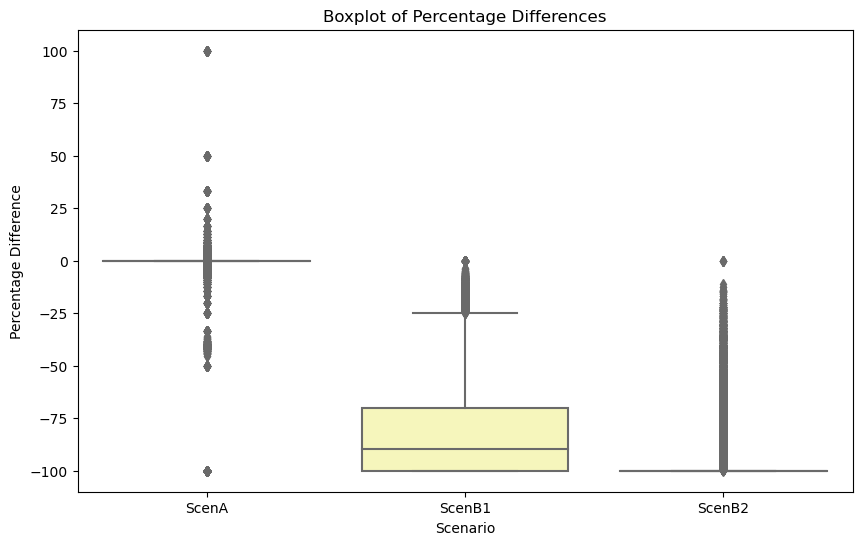

In [61]:

# Create boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=Scenarios[['percent_change_ScenA',
                              'percent_change_ScenB1',
                              'percent_change_ScenB2']],
            palette="Set3")
plt.title('Boxplot of Percentage Differences')
plt.ylabel('Percentage Difference')
plt.xlabel('Scenario')
plt.xticks(ticks=[0, 1, 2], labels=['ScenA', 'ScenB1', 'ScenB2'])
plt.show()

In [62]:
Scenarios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61413 entries, 0 to 61412
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   station_origin         61413 non-null  object 
 1   station_destination    61413 non-null  object 
 2   flows                  61413 non-null  int64  
 3   population             61413 non-null  int64  
 4   jobs                   61413 non-null  int64  
 5   distance               61413 non-null  float64
 6   prodsimest1            61413 non-null  float64
 7   prodsimest2            61413 non-null  float64
 8   prodsimest3            61413 non-null  float64
 9   prodsimest4            61413 non-null  float64
 10  prodsimest5            61413 non-null  float64
 11  percent_change_ScenA   61413 non-null  float64
 12  percent_change_ScenB1  52425 non-null  float64
 13  percent_change_ScenB2  52425 non-null  float64
dtypes: float64(9), int64(3), object(2)
memory usage: 6.6+ 